In [1]:
import cv2
import random
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

from IPython.display import display

In [2]:
imagesDirectory = '../data/images/'

In [3]:
exampleIDs = """SFF_D_1013
zbz-990054280370205508
zbz-990054295100205508
nb-1003704
SFF_D_1578
nb-1001087
SFF_D_1376
SFF_D_1404.002""".split("\n")

In [ ]:
def displayImage(image):
    plt.figure()
    plt.imshow(image)

def displayImages(images):
    for image in images:
        displayImage(image)

In [4]:
exampleImages = [join(imagesDirectory,d + '.jpg') for d in exampleIDs]

In [5]:
images = [cv2.imread(d) for d in exampleImages]
images = [image[:,:,::-1] for image in images]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image is bright
(828, 717, 74, 67)


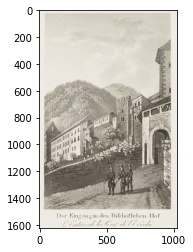

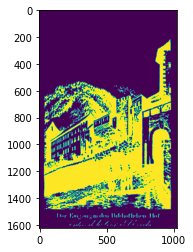

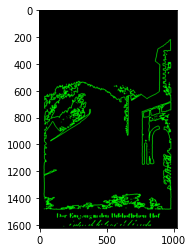

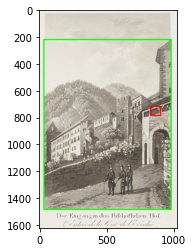

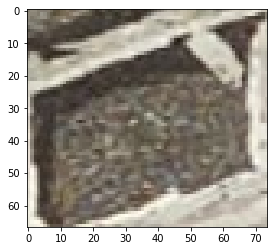

In [70]:
from matplotlib import pyplot as plt

class BSOImageCropping:
    
    extension = 0
    showImages = False
    
    def __init__(self, showImages=False, extension=0):
        self.extension = extension
        self.showImages = showImages
    
    def blurImage(self, image, amount=5):
        return cv2.blur(image.copy(), (amount, amount))
    
    def displayImage(self, image):
        plt.figure()
        plt.imshow(image)
        
    def extendImage(self, image):
        return cv2.copyMakeBorder(image.copy(), self.extension, self.extension, self.extension, self.extension, cv2.BORDER_REPLICATE)
    
    def makeBW(self, image):
        return cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
        
    def cropImage(self, image):        
        extendedImage = self.extendImage(image)
        grayImage = self.makeBW(extendedImage)
        blurImage = self.blurImage(grayImage)
        
        padding = 5
        if blurImage[self.extension+padding][image.shape[1]-padding] > 127:
            thresholdMethod = cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
            print("Image is bright")
        else:
            thresholdMethod = cv2.THRESH_BINARY+cv2.THRESH_OTSU
            print("Image is dark")
        
        ret, thresh = cv2.threshold(blurImage,0,255,thresholdMethod)   
        
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        contourImage = np.zeros(extendedImage.shape)
        cv2.drawContours(contourImage, contours, -1, (0,255,0), 3)
            
        areas = [cv2.contourArea(c) for c in contours]
        indicesOfTwoLargestContours = [areas.index(x) for x in sorted(areas, reverse=True)[:2]]
        
        ratios = []
        for i in indicesOfTwoLargestContours:
            x,y,w,h = cv2.boundingRect(contours[i])
            ratios.append(max(w,h)/min(w,h))
        min_ratio_index = np.argmin(ratios)
        
        drawThickness = 8
        
        rectangleImage = extendedImage.copy()#np.zeros(extendedImage.shape)
        for i in indicesOfTwoLargestContours:
            x,y,w,h = cv2.boundingRect(contours[i])
            cv2.rectangle(rectangleImage, (x, y) , (x + w, y + h), (0,255,0) ,drawThickness)
        
        chosenX, chosenY, chosenW, chosenH = cv2.boundingRect(contours[indicesOfTwoLargestContours[min_ratio_index]])
        cv2.rectangle(rectangleImage, (chosenX, chosenY), (chosenX + chosenW, chosenY + chosenH), (255,0,0), drawThickness)

        #if chosenX < self.extension:
        #difference = self.extension - chosenX
        #chosenX = max(chosenX - difference, 0)
        #chosenW = chosenW - difference
            
        #if chosenY < self.extension:
        ##difference = self.extension - chosenY
        #chosenY = max(chosenY - difference, 0)
        #chosenH = chosenH - difference

        croppedImage = image.copy()[chosenY:chosenY+chosenH, chosenX:chosenX+chosenW]
        
        if self.showImages:
            self.displayImage(image)
            #self.displayImage(extendedImage)
            #self.displayImage(blurImage)
            self.displayImage(thresh)
            self.displayImage(contourImage)
            self.displayImage(rectangleImage)
            self.displayImage(croppedImage)
            
        return chosenX, chosenY, chosenW, chosenH
            
            
detector = BSOImageCropping(showImages=True)
        
for image in images[5:6]:
    print(detector.cropImage(image))